# Load Raw Frames

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import cv2
from skimage.filters import unsharp_mask
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
import pandas as pd

files = sorted(glob.glob('frames/*.png'))
frames = np.array([plt.imread(file) for file in tqdm(files)])
logo = plt.imread('logo.png')
times = pd.date_range(start='2023-06-22 09:00:03.72',
                  end='2023-06-22 09:00:05.01',
                  periods=len(frames))
location = '52.584N, 13.450E'
len(files),frames.shape

100%|██| 53/53 [00:00<00:00, 77.85it/s]


(53, (53, 1100, 1100))

# Find start and end of ISS Transit manually

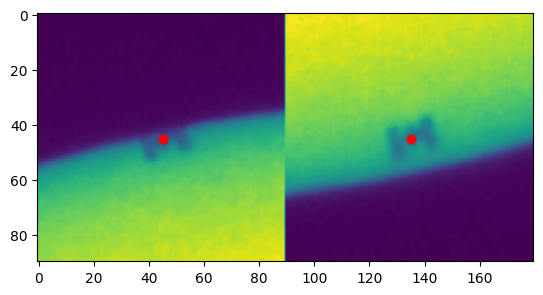

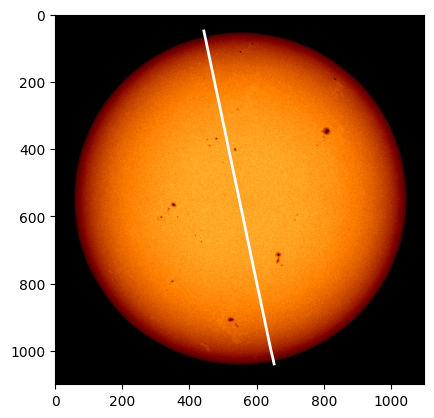

In [2]:
def process_single(channel):
    tmp = copy.copy(channel)
    tmp = (channel*255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=.5, tileGridSize=(3,3))
    tmp = cl_img = clahe.apply(tmp)
    tmp = unsharp_mask(tmp/255., radius=1, amount=3)
    return tmp

linewidth=1  
vmin,vmax=.1,1.2
cmap='afmhot'

psize=90
start_x,start_y=447,67
end_x,end_y=648,1020
xs,ys = np.linspace(start_x,end_x,len(frames)-2).astype(int), np.linspace(start_y,end_y,len(frames)-2).astype(int)

p1 = frames[1][start_y-psize//2:start_y+psize//2,start_x-psize//2:start_x+psize//2]
p2 = frames[-2][end_y-psize//2:end_y+psize//2,end_x-psize//2:end_x+psize//2]

plt.imshow(np.hstack([p1,p2]))
plt.scatter([psize//2,psize+psize//2], [psize//2,psize//2],c='r')
plt.show()

diff_x = np.diff(xs)[0]
diff_y = np.diff(ys)[0]
xs = np.concatenate([[xs[0]-diff_x],xs,[xs[-1]+diff_x]])
ys = np.concatenate([[ys[0]-diff_y],ys,[ys[-1]+diff_y]])

plt.imshow(process_single(frames[1]),vmin=vmin, vmax=vmax,cmap=cmap)
plt.plot(xs,ys,c='w',lw=2)
plt.show()

# Loop over frames and dump plots in tmp/

In [3]:
plt.style.use('dark_background')

for i,frame in tqdm(enumerate(frames)):
    tmp = process_single(frame)

    fig = plt.figure(figsize=(5,7))
    ax = fig.gca()
    ax.imshow(tmp,vmin=vmin, vmax=vmax,cmap=cmap)
    ax.axis('off')
    ax.text(tmp.shape[1],0,location+'\n'+'\n'.join(str(times[i])[:22].strip().split(' ')),ha='right',va='top',color='white')
    ax.text(tmp.shape[1]//2,0,'ISS Solar Transit',ha='center',va='top',color='white')

    xi,yi = xs[i],ys[i]
    patch = frame[yi-psize//2:yi+psize//2,xi-psize//2:xi+psize//2]
    axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.38, -.2, .25, .25),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
    axins.set_xticks([])
    axins.set_yticks([])
    rect = patches.Rectangle((xi-psize//2, yi-psize//2), psize, psize, linewidth=linewidth, edgecolor='w', facecolor='none')
    ax.add_patch(rect)
    ax.plot([xi,tmp.shape[1]//2],[yi+psize//2,tmp.shape[1]],color='w',linewidth=linewidth)    
    axins.imshow(patch,vmin=vmin, vmax=vmax,cmap=cmap)

    axins2 = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.0, .875, .15, .15),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
    axins2.imshow(logo[:,:,0],cmap='Greys')
    axins2.axis('off')

    plt.tight_layout()
    plt.savefig(f'tmp/frame_{i}.png', bbox_inches='tight', pad_inches=.1, dpi=200)
    plt.close()
    #break

0it [00:00, ?it/s]/tmp/ipykernel_1165734/2679282710.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
53it [00:43,  1.21it/s]


# Load animated frames and create GIF and mp4

In [4]:
import imageio 

fps=20
gif = (np.array([plt.imread(f'tmp/frame_{i}.png') for i in range(len(frames))])*255).astype(np.uint8)

imageio.mimsave('iss_solar_transit.gif', gif,fps=fps)
imageio.mimsave('iss_solar_transit_downsampled.gif', gif[:,::2,::2],fps=fps)

writer = imageio.get_writer('iss_solar_transit.mp4', fps = fps, codec='mjpeg', quality=10)
for im in gif:
    writer.append_data(im)
writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (980, 1232) to (992, 1232) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Incompatible pixel format 'yuv420p' for codec 'mjpeg', auto-selecting format 'yuvj420p'
[swscaler @ 0x58dfc80] deprecated pixel format used, make sure you did set range correctly
